https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

/home/nagae/anaconda3/envs/gpu-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [6]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [7]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [8]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [9]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [10]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [11]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [12]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [13]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [14]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [15]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [16]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [17]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [18]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43363, 73)
CPU times: user 5 s, sys: 376 ms, total: 5.38 s
Wall time: 1.74 s


In [19]:
full.head()

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df = take_n_atoms(full, 10)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')

In [21]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 38), (8673, 38), (34690,), (8673,))

In [22]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 25,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [23]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.283513	valid_1's l1: 0.445556
[200]	training's l1: 0.197698	valid_1's l1: 0.409865
[300]	training's l1: 0.151573	valid_1's l1: 0.39582
[400]	training's l1: 0.121348	valid_1's l1: 0.387725
[500]	training's l1: 0.100032	valid_1's l1: 0.382911
[600]	training's l1: 0.0840414	valid_1's l1: 0.379714
[700]	training's l1: 0.0718533	valid_1's l1: 0.377831
[800]	training's l1: 0.0621238	valid_1's l1: 0.37602
[900]	training's l1: 0.0542927	valid_1's l1: 0.374726
[1000]	training's l1: 0.0478482	valid_1's l1: 0.373658
[1100]	training's l1: 0.0425389	valid_1's l1: 0.372942
[1200]	training's l1: 0.0380256	valid_1's l1: 0.372286
[1300]	training's l1: 0.0341548	valid_1's l1: 0.371787
[1400]	training's l1: 0.030845	valid_1's l1: 0.371334
[1500]	training's l1: 0.0280127	valid_1's l1: 0.370867
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0280127	valid_1's l1: 0.370867


-0.9919129918909441

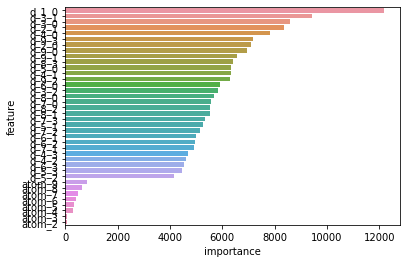

In [24]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [25]:
df.head()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
0,1,1,0,0,0,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.688900
1,1,1,0,0,0,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.689098
2,1,1,0,0,0,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.690498
3,1,6,8,1,0,0,0,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.525200
4,1,6,1,8,0,0,0,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.735901


In [27]:
import lightgbm as lgbm
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=218)

X_data, y_data = build_x_y_data(train_csv, coupling_type='1JHN', n_atoms=7)

def objective(trial):
    drop_rate = trial.suggest_uniform('drop_rate', 0, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.8, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 5, 1000)
    verbosity = trial.suggest_int('verbosity', -1, 1)
    num_boost_round = trial.suggest_int('num_boost_round', 10, 100000)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100000)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 500)
 
    params = {"objective": "binary",
              "boosting_type": "gbdt",
              "learning_rate": learning_rate,
              "num_leaves": num_leaves,
              "max_bin": 256,
              "feature_fraction": feature_fraction,
              "verbosity": verbosity,
              "drop_rate": drop_rate,
              "is_unbalance": False,
              "max_drop": 50,
              "min_child_samples": min_child_samples,
              "min_child_weight": min_child_weight,
              "min_split_gain": 0,
              "min_data_in_leaf": min_data_in_leaf,
              "subsample": subsample
              }
 
    x_score = []
    final_cv_train = np.zeros(len(y_data))
   # final_cv_pred = np.zeros(len(test_id))
 
    cv_train = np.zeros(len(y_data))
    #cv_pred = np.zeros(len(test_id))
 
    params['seed'] = 0
 
    kf = kfold.split(X_data, y_data)
 
    best_trees = []
    fold_scores = []
 
    for i, (train_fold, validate) in enumerate(kf):
        print('kfold_index:', i)
        X_train, X_validate, label_train, label_validate = \
            X_data[train_fold, :], X_data[validate, :], y_data[train_fold], y_data[validate]
        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, verbose_eval=100,
                        early_stopping_rounds=100)
        best_trees.append(bst.best_iteration)
#        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)
 
        score = mean_absolute_error(label_validate,cv_train[validate])
        print(score)
        fold_scores.append(score)
 
 
    #cv_pred /= 3
    final_cv_train += cv_train
    #final_cv_pred += cv_pred
 
    print(fold_scores)
    print(best_trees, np.mean(best_trees))
    print(X_data.shape)
    print(cv_train.shape)
 
    x_score.append(mean_absolute_error(y_data, cv_train))
    print(x_score)
 
    return x_score[0]
 
study = optuna.create_study()
study.optimize(objective, n_trials=150)

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:28,036] Finished trial#0 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:28,300] Finished trial#1 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:28,570] Finished trial#2 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:28,851] Finished trial#3 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:29,203] Finished trial#4 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:29,507] Finished trial#5 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:29,811] Finished trial#6 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:30,093] Finished trial#7 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:30,370] Finished trial#8 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:30,679] Finished trial#9 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:31,013] Finished trial#10 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:31,338] Finished trial#11 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:31,651] Finished trial#12 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:31,966] Finished trial#13 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:32,372] Finished trial#14 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:32,715] Finished trial#15 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:33,063] Finished trial#16 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:33,480] Finished trial#17 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:33,836] Finished trial#18 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:34,204] Finished trial#19 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:34,624] Finished trial#20 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:34,986] Finished trial#21 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:35,339] Finished trial#22 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:35,679] Finished trial#23 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:36,023] Finished trial#24 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:36,398] Finished trial#25 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:36,735] Finished trial#26 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:37,100] Finished trial#27 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:37,442] Finished trial#28 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:37,817] Finished trial#29 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:38,159] Finished trial#30 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:38,507] Finished trial#31 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:38,860] Finished trial#32 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:39,217] Finished trial#33 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:39,590] Finished trial#34 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:39,944] Finished trial#35 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:40,317] Finished trial#36 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:40,693] Finished trial#37 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:41,078] Finished trial#38 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:41,448] Finished trial#39 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:41,829] Finished trial#40 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:42,196] Finished trial#41 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:42,597] Finished trial#42 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:43,038] Finished trial#43 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:43,404] Finished trial#44 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:43,798] Finished trial#45 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:44,193] Finished trial#46 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:44,585] Finished trial#47 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:44,976] Finished trial#48 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:45,384] Finished trial#49 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:45,768] Finished trial#50 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:46,156] Finished trial#51 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:46,557] Finished trial#52 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:46,951] Finished trial#53 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:47,366] Finished trial#54 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:47,789] Finished trial#55 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:48,186] Finished trial#56 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:48,584] Finished trial#57 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:48,998] Finished trial#58 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:49,425] Finished trial#59 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:49,895] Finished trial#60 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:50,350] Finished trial#61 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:50,779] Finished trial#62 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:51,211] Finished trial#63 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:51,664] Finished trial#64 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:52,091] Finished trial#65 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:52,577] Finished trial#66 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:53,019] Finished trial#67 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:53,437] Finished trial#68 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:53,884] Finished trial#69 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:54,306] Finished trial#70 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:54,732] Finished trial#71 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:55,187] Finished trial#72 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:55,616] Finished trial#73 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:56,067] Finished trial#74 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:56,525] Finished trial#75 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:56,970] Finished trial#76 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:57,451] Finished trial#77 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:57,964] Finished trial#78 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:58,405] Finished trial#79 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:58,853] Finished trial#80 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:59,292] Finished trial#81 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:49:59,740] Finished trial#82 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:00,196] Finished trial#83 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:00,645] Finished trial#84 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:01,090] Finished trial#85 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:01,621] Finished trial#86 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:02,066] Finished trial#87 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:02,569] Finished trial#88 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:03,028] Finished trial#89 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:03,532] Finished trial#90 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:03,981] Finished trial#91 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:04,432] Finished trial#92 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:04,897] Finished trial#93 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:05,367] Finished trial#94 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:05,912] Finished trial#95 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:06,403] Finished trial#96 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:06,909] Finished trial#97 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:07,405] Finished trial#98 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:07,904] Finished trial#99 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:08,411] Finished trial#100 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:08,889] Finished trial#101 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:09,363] Finished trial#102 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:09,843] Finished trial#103 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:10,328] Finished trial#104 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:10,822] Finished trial#105 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:11,310] Finished trial#106 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:11,805] Finished trial#107 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:12,293] Finished trial#108 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:12,817] Finished trial#109 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:13,294] Finished trial#110 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:13,770] Finished trial#111 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:14,255] Finished trial#112 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:14,762] Finished trial#113 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:15,287] Finished trial#114 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:15,809] Finished trial#115 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:16,366] Finished trial#116 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:16,883] Finished trial#117 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:17,423] Finished trial#118 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:17,973] Finished trial#119 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:18,473] Finished trial#120 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:18,963] Finished trial#121 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:19,459] Finished trial#122 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:19,956] Finished trial#123 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:20,470] Finished trial#124 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:20,997] Finished trial#125 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:21,502] Finished trial#126 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:22,013] Finished trial#127 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:22,566] Finished trial#128 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:23,085] Finished trial#129 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:23,635] Finished trial#130 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:24,244] Finished trial#131 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:24,813] Finished trial#132 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:25,385] Finished trial#133 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:25,928] Finished trial#134 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:26,454] Finished trial#135 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:26,968] Finished trial#136 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:27,477] Finished trial#137 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:27,998] Finished trial#138 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:28,535] Finished trial#139 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:29,095] Finished trial#140 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:29,634] Finished trial#141 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:30,174] Finished trial#142 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:30,715] Finished trial#143 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:31,264] Finished trial#144 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:31,789] Finished trial#145 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:32,326] Finished trial#146 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:32,878] Finished trial#147 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:33,448] Finished trial#148 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


kfold_index: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.4349565981664
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.549965994906024
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0
46.454733982115215
[46.4349565981664, 46.549965994906024, 46.454733982115215]
[1, 1, 1] 1.0
(43363, 23)
(43363,)
[46.479884488950496]


[I 2019-08-12 20:50:33,986] Finished trial#149 resulted in value: 46.479884488950496. Current best value is 46.479884488950496 with parameters: {'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}.


In [28]:
print(study.best_params)
print(study.best_value)

{'drop_rate': 0.040960108343318535, 'feature_fraction': 0.6584099063624647, 'learning_rate': 0.9639550458959371, 'subsample': 0.8500161901682345, 'num_leaves': 383, 'verbosity': 1, 'num_boost_round': 79917, 'min_data_in_leaf': 72387, 'min_child_samples': 290, 'min_child_weight': 491}
46.479884488950496


In [26]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [29]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=3000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [30]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 5
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.318865	valid_1's l1: 0.463026
[200]	training's l1: 0.235867	valid_1's l1: 0.423691
[300]	training's l1: 0.188683	valid_1's l1: 0.407229
[400]	training's l1: 0.157509	valid_1's l1: 0.39844
[500]	training's l1: 0.134101	valid_1's l1: 0.392723
[600]	training's l1: 0.116837	valid_1's l1: 0.38907
[700]	training's l1: 0.10274	valid_1's l1:

[600]	training's l1: 0.117618	valid_1's l1: 0.385725
[700]	training's l1: 0.103641	valid_1's l1: 0.383031
[800]	training's l1: 0.092285	valid_1's l1: 0.381301
[900]	training's l1: 0.0829065	valid_1's l1: 0.379605
[1000]	training's l1: 0.0749165	valid_1's l1: 0.378181
[1100]	training's l1: 0.0680995	valid_1's l1: 0.377211
[1200]	training's l1: 0.0621036	valid_1's l1: 0.376236
[1300]	training's l1: 0.056958	valid_1's l1: 0.37564
[1400]	training's l1: 0.0524324	valid_1's l1: 0.375175
[1500]	training's l1: 0.0485381	valid_1's l1: 0.37468
[1600]	training's l1: 0.0449936	valid_1's l1: 0.374166
[1700]	training's l1: 0.0418165	valid_1's l1: 0.373782
[1800]	training's l1: 0.0390199	valid_1's l1: 0.373718
[1900]	training's l1: 0.0364904	valid_1's l1: 0.373304
[2000]	training's l1: 0.0342112	valid_1's l1: 0.373177
[2100]	training's l1: 0.0321273	valid_1's l1: 0.373012
[2200]	training's l1: 0.030228	valid_1's l1: 0.372931
[2300]	training's l1: 0.0285463	valid_1's l1: 0.372818
[2400]	training's l1:

[800]	training's l1: 0.634039	valid_1's l1: 0.841631
[900]	training's l1: 0.607013	valid_1's l1: 0.827973
[1000]	training's l1: 0.581883	valid_1's l1: 0.815746
[1100]	training's l1: 0.55921	valid_1's l1: 0.805063
[1200]	training's l1: 0.538553	valid_1's l1: 0.795723
[1300]	training's l1: 0.519433	valid_1's l1: 0.787333
[1400]	training's l1: 0.501918	valid_1's l1: 0.779527
[1500]	training's l1: 0.485965	valid_1's l1: 0.772603
[1600]	training's l1: 0.470462	valid_1's l1: 0.766181
[1700]	training's l1: 0.45614	valid_1's l1: 0.760846
[1800]	training's l1: 0.443132	valid_1's l1: 0.755796
[1900]	training's l1: 0.43042	valid_1's l1: 0.7509
[2000]	training's l1: 0.418543	valid_1's l1: 0.746675
[2100]	training's l1: 0.407051	valid_1's l1: 0.742343
[2200]	training's l1: 0.396427	valid_1's l1: 0.73869
[2300]	training's l1: 0.386545	valid_1's l1: 0.735346
[2400]	training's l1: 0.376934	valid_1's l1: 0.732027
[2500]	training's l1: 0.367659	valid_1's l1: 0.729009
[2600]	training's l1: 0.358775	valid

[1100]	training's l1: 0.0950467	valid_1's l1: 0.181263
[1200]	training's l1: 0.0903971	valid_1's l1: 0.179641
[1300]	training's l1: 0.0861781	valid_1's l1: 0.178093
[1400]	training's l1: 0.0822195	valid_1's l1: 0.176856
[1500]	training's l1: 0.0786571	valid_1's l1: 0.175649
[1600]	training's l1: 0.0752936	valid_1's l1: 0.174592
[1700]	training's l1: 0.0722023	valid_1's l1: 0.173657
[1800]	training's l1: 0.0692761	valid_1's l1: 0.172795
[1900]	training's l1: 0.0666294	valid_1's l1: 0.172059
[2000]	training's l1: 0.0641023	valid_1's l1: 0.171345
[2100]	training's l1: 0.0618268	valid_1's l1: 0.170728
[2200]	training's l1: 0.0595946	valid_1's l1: 0.170155
[2300]	training's l1: 0.0575505	valid_1's l1: 0.169609
[2400]	training's l1: 0.0556437	valid_1's l1: 0.169154
[2500]	training's l1: 0.0537717	valid_1's l1: 0.168691
[2600]	training's l1: 0.0520322	valid_1's l1: 0.168273
[2700]	training's l1: 0.0503851	valid_1's l1: 0.16793
[2800]	training's l1: 0.048814	valid_1's l1: 0.167563
[2900]	train

[1300]	training's l1: 0.0407202	valid_1's l1: 0.141761
[1400]	training's l1: 0.0381585	valid_1's l1: 0.141093
[1500]	training's l1: 0.0358103	valid_1's l1: 0.140478
[1600]	training's l1: 0.0337593	valid_1's l1: 0.140035
[1700]	training's l1: 0.0318637	valid_1's l1: 0.139575
[1800]	training's l1: 0.0301361	valid_1's l1: 0.139224
[1900]	training's l1: 0.0285345	valid_1's l1: 0.138814
[2000]	training's l1: 0.0271346	valid_1's l1: 0.138519
[2100]	training's l1: 0.0258264	valid_1's l1: 0.138218
[2200]	training's l1: 0.02459	valid_1's l1: 0.13801
[2300]	training's l1: 0.0234452	valid_1's l1: 0.137757
[2400]	training's l1: 0.0224133	valid_1's l1: 0.137575
[2500]	training's l1: 0.0214397	valid_1's l1: 0.137431
[2600]	training's l1: 0.0205474	valid_1's l1: 0.137257
[2700]	training's l1: 0.0197037	valid_1's l1: 0.137063
[2800]	training's l1: 0.018918	valid_1's l1: 0.136894
[2900]	training's l1: 0.0181883	valid_1's l1: 0.136758
[3000]	training's l1: 0.0174931	valid_1's l1: 0.136628
Did not meet e

[1500]	training's l1: 0.224108	valid_1's l1: 0.305598
[1600]	training's l1: 0.218289	valid_1's l1: 0.302521
[1700]	training's l1: 0.212831	valid_1's l1: 0.299657
[1800]	training's l1: 0.207842	valid_1's l1: 0.297067
[1900]	training's l1: 0.202963	valid_1's l1: 0.294648
[2000]	training's l1: 0.198464	valid_1's l1: 0.292487
[2100]	training's l1: 0.194194	valid_1's l1: 0.290444
[2200]	training's l1: 0.19008	valid_1's l1: 0.288492
[2300]	training's l1: 0.186158	valid_1's l1: 0.286682
[2400]	training's l1: 0.182541	valid_1's l1: 0.285038
[2500]	training's l1: 0.178971	valid_1's l1: 0.283456
[2600]	training's l1: 0.175497	valid_1's l1: 0.281958
[2700]	training's l1: 0.172167	valid_1's l1: 0.280409
[2800]	training's l1: 0.169055	valid_1's l1: 0.279046
[2900]	training's l1: 0.16604	valid_1's l1: 0.277757
[3000]	training's l1: 0.163173	valid_1's l1: 0.27651
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.163173	valid_1's l1: 0.27651
2JHC Fold 0, logMAE: -1.28551000562357

2JHC Fold 4, logMAE: -1.2820965445158718
*** Training Model for 3JHH ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.271414	valid_1's l1: 0.284276
[200]	training's l1: 0.225978	valid_1's l1: 0.246926
[300]	

[200]	training's l1: 0.22554	valid_1's l1: 0.248828
[300]	training's l1: 0.199955	valid_1's l1: 0.229729
[400]	training's l1: 0.18248	valid_1's l1: 0.217465
[500]	training's l1: 0.168945	valid_1's l1: 0.208859
[600]	training's l1: 0.15813	valid_1's l1: 0.20215
[700]	training's l1: 0.14902	valid_1's l1: 0.196772
[800]	training's l1: 0.141328	valid_1's l1: 0.192417
[900]	training's l1: 0.134547	valid_1's l1: 0.188762
[1000]	training's l1: 0.128532	valid_1's l1: 0.185534
[1100]	training's l1: 0.123194	valid_1's l1: 0.182818
[1200]	training's l1: 0.118293	valid_1's l1: 0.180546
[1300]	training's l1: 0.113761	valid_1's l1: 0.178449
[1400]	training's l1: 0.109674	valid_1's l1: 0.176659
[1500]	training's l1: 0.105872	valid_1's l1: 0.174961
[1600]	training's l1: 0.102373	valid_1's l1: 0.173463
[1700]	training's l1: 0.0990381	valid_1's l1: 0.172122
[1800]	training's l1: 0.0959131	valid_1's l1: 0.170875
[1900]	training's l1: 0.0930128	valid_1's l1: 0.169788
[2000]	training's l1: 0.0902573	valid_

[400]	training's l1: 0.391894	valid_1's l1: 0.423608
[500]	training's l1: 0.370378	valid_1's l1: 0.407175
[600]	training's l1: 0.352843	valid_1's l1: 0.394452
[700]	training's l1: 0.337857	valid_1's l1: 0.383691
[800]	training's l1: 0.324905	valid_1's l1: 0.374698
[900]	training's l1: 0.313102	valid_1's l1: 0.366643
[1000]	training's l1: 0.303281	valid_1's l1: 0.36032
[1100]	training's l1: 0.294228	valid_1's l1: 0.354573
[1200]	training's l1: 0.285789	valid_1's l1: 0.349405
[1300]	training's l1: 0.277969	valid_1's l1: 0.34474
[1400]	training's l1: 0.270905	valid_1's l1: 0.340609
[1500]	training's l1: 0.264368	valid_1's l1: 0.336775
[1600]	training's l1: 0.258379	valid_1's l1: 0.333436
[1700]	training's l1: 0.252815	valid_1's l1: 0.330378
[1800]	training's l1: 0.247553	valid_1's l1: 0.327552
[1900]	training's l1: 0.242388	valid_1's l1: 0.32482
[2000]	training's l1: 0.237564	valid_1's l1: 0.322321
[2100]	training's l1: 0.233115	valid_1's l1: 0.320158
[2200]	training's l1: 0.228673	valid_

[500]	training's l1: 0.0699635	valid_1's l1: 0.126261
[600]	training's l1: 0.0631307	valid_1's l1: 0.123441
[700]	training's l1: 0.0574067	valid_1's l1: 0.121307
[800]	training's l1: 0.0526648	valid_1's l1: 0.119627
[900]	training's l1: 0.0485929	valid_1's l1: 0.11806
[1000]	training's l1: 0.0450832	valid_1's l1: 0.116789
[1100]	training's l1: 0.0418889	valid_1's l1: 0.115737
[1200]	training's l1: 0.0391767	valid_1's l1: 0.114859
[1300]	training's l1: 0.0366864	valid_1's l1: 0.114048
[1400]	training's l1: 0.0344687	valid_1's l1: 0.113367
[1500]	training's l1: 0.0324841	valid_1's l1: 0.112833
[1600]	training's l1: 0.0307103	valid_1's l1: 0.11234
[1700]	training's l1: 0.029094	valid_1's l1: 0.111926
[1800]	training's l1: 0.0275995	valid_1's l1: 0.11152
[1900]	training's l1: 0.0262292	valid_1's l1: 0.111173
[2000]	training's l1: 0.0249585	valid_1's l1: 0.110823
[2100]	training's l1: 0.0238215	valid_1's l1: 0.110544
[2200]	training's l1: 0.0227494	valid_1's l1: 0.110306
[2300]	training's l

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

In [ ]:
np.mean(list(cv_scores.values()))

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/sub_lightgbm_maxdepth=25.csv')

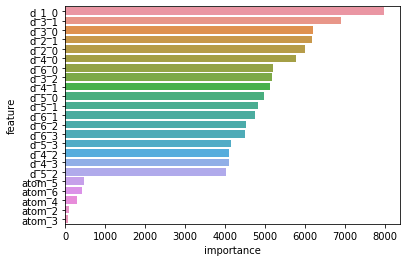

In [44]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));